# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot
based on code from 

In [3]:
import cmocean.cm as cm
import glob
from matplotlib.colors import LogNorm, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import scipy.interpolate as interp

from salishsea_tools import nc_tools

%matplotlib inline

### get grid info

In [4]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdepw_1d)

### Hourly particle crossing, 1 day run

In [5]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/JDF_salish/14sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

In [6]:
def get_data(mydata, section, time):
    lons = mydata.final_lon[(mydata.final_section==section) & (mydata.init_t==time)]
    depths = depthf(mydata.final_z[(mydata.final_section==section) & (mydata.init_t==time)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section) & (mydata.init_t==time)]
    return lons, depths, transports

#### SoG3

In [7]:
section = 4

figrid = 266 #fortran igrid
igrid = figrid-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
u_lons = mymesh.glamv[0, igrid]    # note switch to v with the switch from t to f
f_lons = mymesh.glamf[0, igrid]
w_depths = mymesh.gdepw_1d

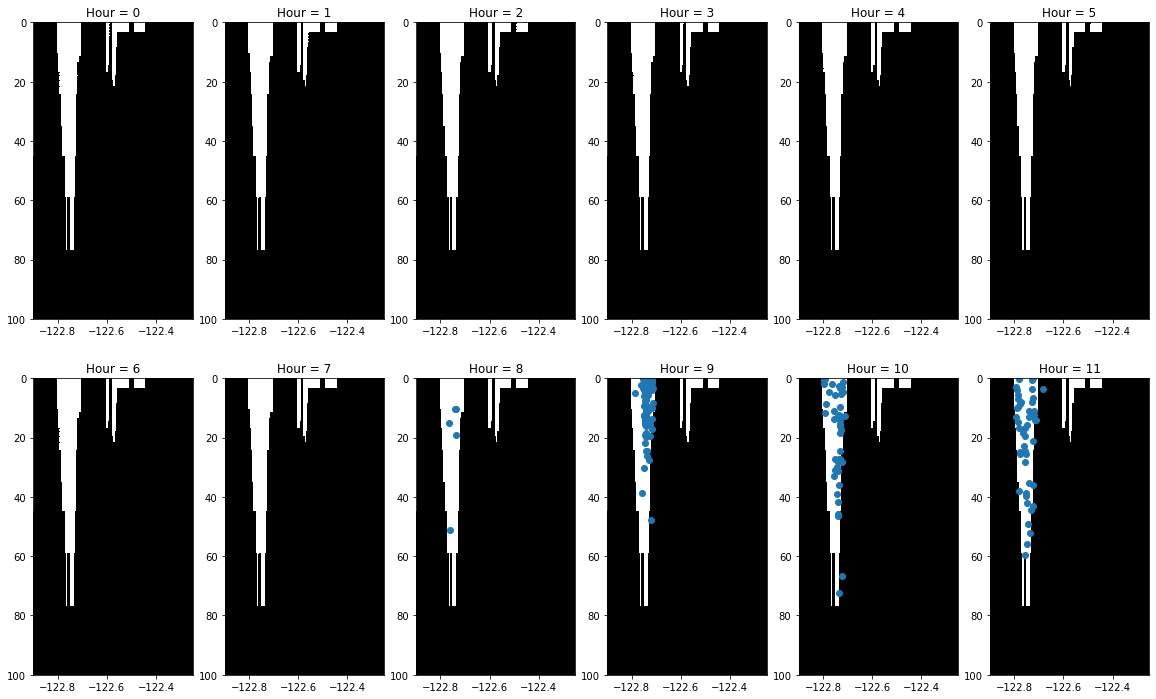

In [8]:

fig, axs = plt.subplots(2, 6, figsize=(20, 12))
x, y = np.meshgrid(u_lons, w_depths)
for hour in range(12):
    ax = axs[int(hour/6), hour-6*int(hour/6)]
    lons, depths, transports = get_data(mydata, section, time1+hour)
    ax.pcolormesh(x, y, fmask, cmap='Greys_r',  shading='auto')
    ax.plot(lons, depths, 'o')
    ax.invert_yaxis()
    ax.set_xlim((-122.9, -122.25))
    ax.set_ylim((100, 0))
    ax.set_title("Hour = "+str(hour))

### puget 1

In [9]:
section = 2

figrid = 204
igrid = figrid-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
u_lons = mymesh.glamv[0, igrid]    # note switch to v with the switch from t to f
f_lons = mymesh.glamf[0, igrid]
w_depths = mymesh.gdepw_1d

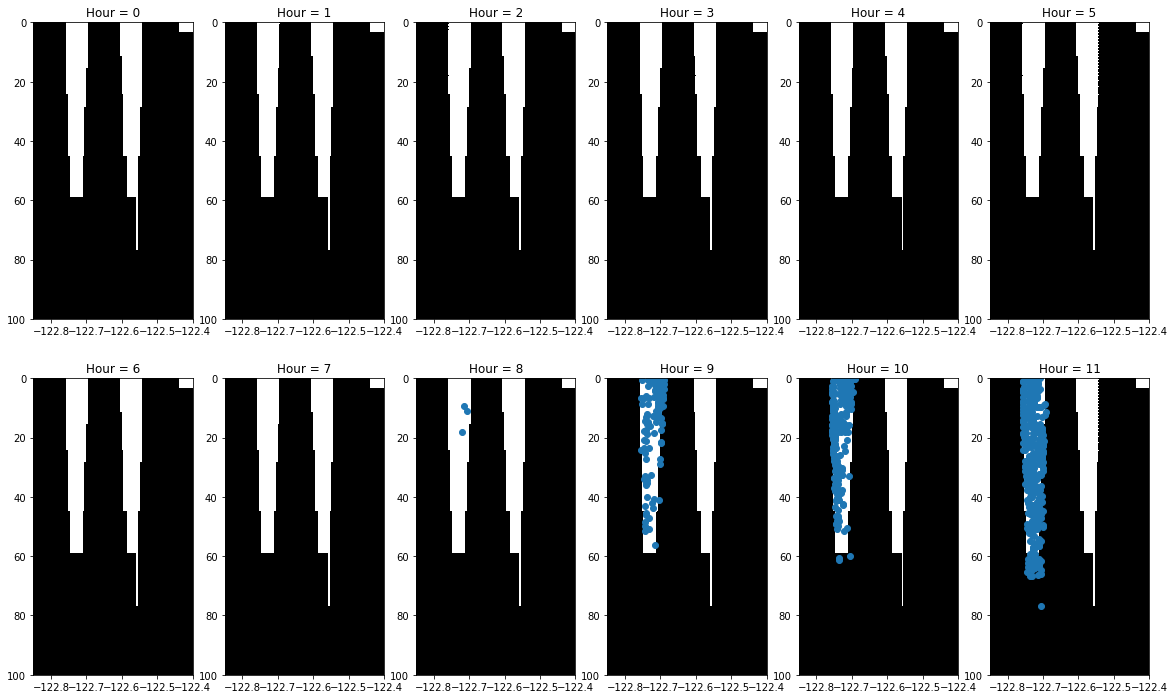

In [10]:

fig, axs = plt.subplots(2, 6, figsize=(20, 12))
x, y = np.meshgrid(u_lons, w_depths)
for hour in range(12):
    ax = axs[int(hour/6), hour-6*int(hour/6)]
    lons, depths, transports = get_data(mydata, section, time1+hour)
    ax.pcolormesh(x, y, fmask, cmap='Greys_r',  shading='auto')
    ax.plot(lons, depths, 'o')
    ax.invert_yaxis()
    ax.set_xlim((-122.85, -122.4))
    ax.set_ylim((100, 0))
    ax.set_title("Hour = "+str(hour))

clearly taking the figrid from sections.txt doesn't QUITE work (especially visible in hour 11 where many of the particles come in at a deph that is ground according to the grid)

### Daily flux, 1 day run

In [11]:
salfile = '/results/SalishSea/nowcast-green.201812/14sep17/SalishSea_1d_20170914_20170914_grid_T.nc'

In [12]:
def draw_patches(fmask, ll, ul, u_lons, w_depths):
    topo = []
    for i in range(ll,ul):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((u_lons[i], w_depths[j]), u_lons[i+1]-u_lons[i], w_depths[j+1]-w_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood')
    return(pc)

In [52]:
t_ys = mymesh['e1t'][0,266,286:307]
t_zs = mymesh['e3t_0'][0,:,266,286:307]
print(np.shape(t_zs))

t_cross = np.zeros_like(t_zs)

for i in range(0,40):
    t_cross[i,:] = t_ys * t_zs[i,:]
    
print(t_cross[0,:])
print(t_cross[30,:])

(40, 21)
[439.2606924  439.24328863 439.22589224 439.20850328 439.19112179
 439.17374779 439.15638134 439.13902248 439.12167124 439.10432765
 439.08699177 439.06966362 439.05234324 439.03503067 439.01772595
 439.00042911 438.98314019 438.96585923 438.94858626 438.93132132
 438.91406444]
[11683.12993939 11682.66704683 11682.20435059 11681.74185183
 11681.27955188 11680.81745128 11680.35555135 11679.89385325
 11679.43235767 11678.9710659  11678.50997887 11678.04909769
 11677.58842296 11677.12795614 11676.66769803 11676.20764951
 11675.74781173 11675.28818556 11674.82877193 11674.36957177
 11673.91058609]


In [82]:
def transportCS(section, lonW, lonE, figrid, maxdepth, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    u_lons = mymesh.glamv[0, igrid]    # note switch to v with the switch from t to f
    f_lons = mymesh.glamf[0, igrid]
    w_depths = mymesh.gdepw_1d
    
#     m2lon = ((u_lons[lonE]-u_lons[lonW])/(mymesh.e2f[0, igrid, lonW:lonE].sum()))
#     tmax = 997
#     vvmax = 997/float(m2lon)*24/tmax
    xs, ys = np.meshgrid(np.array(mymesh.glamv[0, igrid]), np.array(mymesh.gdept_1d))
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]
    
    #vmax = vvmax*tmax/float(transports.sum())
    #tt_cross = np.ravel(t_cross)
    #flow_ms = transports/tt_cross
#     flow_ms = transports
    t_vmax = max(transports).values
    print(t_vmax)
    
    c, xedge, yedge, im = ax.hist2d(lons, 
                            depths,
                            weights=transports,
                            bins=[np.array(f_lons[lonW:lonE]), w_depths[0]], cmap=cm.amp, vmax=t_vmax)
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]))
    ax.add_collection(pc)
    cb1 = fig.colorbar(im, ax=ax) 
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, f'{vmax * float(m2lon) * float(transports.sum())/24.:.2f}'])
    cb1.set_label('m$^{3}$ s$^{-1}$', labelpad=-20)
    salinity = 0.5*(np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid],
                    mask=1-tmask[:, igrid]) +
                np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid+1],
                    mask=1-tmask[:, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g')
    ax.clabel(CS, inline=1, fontsize=7)
    ax.invert_yaxis()
    # ax.set_xlim((-123.32, -123.05))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()

In [79]:
max(tr).values

array(996.83726452)

996.8372645200992


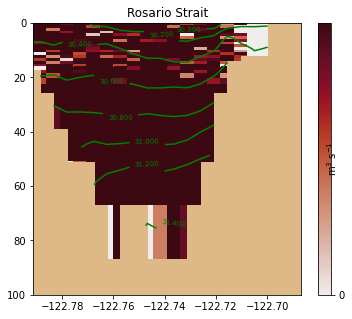

In [83]:
transportCS(4, 286, 307, 266, 100, "Rosario Strait")

In [64]:
type(im)

matplotlib.collections.QuadMesh

In [51]:
t_ys = mymesh['e1t'][0,266,286:307]
t_zs = mymesh['e3t_0'][0,:,266,286:307]
print(np.shape(t_zs))

t_cross = np.zeros_like(t_zs)

for i in range(0,40):
    t_cross[i,:] = t_ys * t_zs[i,:]
    
print(t_cross[0,:])
print(t_cross[30,:])

(40, 21)
[439.2606924  439.24328863 439.22589224 439.20850328 439.19112179
 439.17374779 439.15638134 439.13902248 439.12167124 439.10432765
 439.08699177 439.06966362 439.05234324 439.03503067 439.01772595
 439.00042911 438.98314019 438.96585923 438.94858626 438.93132132
 438.91406444]
[11683.12993939 11682.66704683 11682.20435059 11681.74185183
 11681.27955188 11680.81745128 11680.35555135 11679.89385325
 11679.43235767 11678.9710659  11678.50997887 11678.04909769
 11677.58842296 11677.12795614 11676.66769803 11676.20764951
 11675.74781173 11675.28818556 11674.82877193 11674.36957177
 11673.91058609]


In [45]:
print(mymesh)

<xarray.Dataset>
Dimensions:       (t: 1, x: 398, y: 898, z: 40)
Dimensions without coordinates: t, x, y, z
Data variables:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    time_counter  (t) datetime64[ns] 1900-01-01
    tmask         (t, z, y, x) int8 ...
    umask         (t, z, y, x) int8 ...
    vmask         (t, z, y, x) int8 ...
    fmask         (t, z, y, x) int8 ...
    tmaskutil     (t, y, x) int8 ...
    umaskutil     (t, y, x) int8 ...
    vmaskutil     (t, y, x) int8 ...
    fmaskutil     (t, y, x) int8 ...
    glamt         (t, y, x) float32 ...
    glamu         (t, y, x) float32 ...
    glamv         (t, y, x) float32 ...
    glamf         (t, y, x) float32 ...
    gphit         (t, y, x) float32 ...
    gphiu         (t, y, x) float32 ...
    gphiv         (t, y, x) float32 ...
    gphif         (t, y, x) float32 ...
    e1t           (t, y, x) float64 ...
    e1u           (t, y, x) float64 ...
    e1v           (t, y, x) float64 ...
    e1

<xarray.DataArray 'final_transp' (ntraj: 3446)>
array([363.885228, 586.784861, 249.117263, ...,  43.921705,   4.336663,
        30.052172])
Dimensions without coordinates: ntraj
Attributes:
    title:     What is final_transp ?
    longname:  Final transport
    units:     m3/s

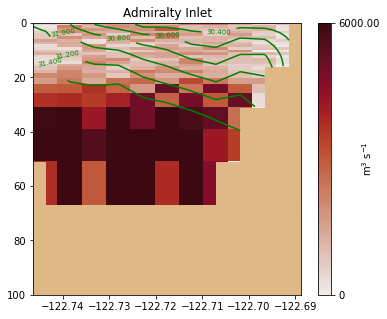

In [15]:
transportCS(2, 255, 267, 204, 100, "Admiralty Inlet")

<xarray.DataArray 'final_transp' (ntraj: 7445)>
array([228.081512, 228.081512, 242.00275 , ..., 140.770456,  51.925309,
        91.766004])
Dimensions without coordinates: ntraj
Attributes:
    title:     What is final_transp ?
    longname:  Final transport
    units:     m3/s

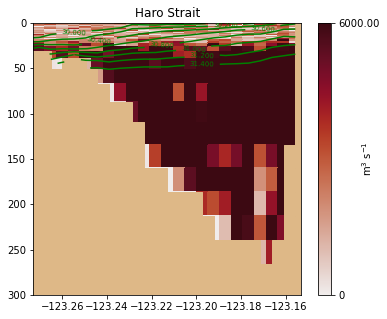

In [16]:
transportCS(5, 218, 242, 304, 300, "Haro Strait")

ValueError: not enough values to unpack (expected 2, got 1)

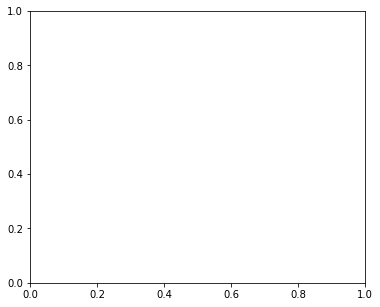

In [26]:
figrid = 266
lonW = 286
lonE = 307
maxdepth = 100



igrid = figrid-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
u_lons = mymesh.glamv[0, igrid]    # note switch to v with the switch from t to f
f_lons = mymesh.glamf[0, igrid]
w_depths = mymesh.gdepw_1d
    
m2lon = ((u_lons[lonE]-u_lons[lonW])/(mymesh.e2f[0, igrid, lonW:lonE].sum()))
tmax = 997
vvmax = 5000/float(m2lon)*24/tmax
xs, ys = np.meshgrid(np.array(mymesh.glamv[0, igrid]), np.array(mymesh.gdept_1d))
    
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
lons = mydata.final_lon[(mydata.final_section==section)]
depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
transports = mydata.final_transp[(mydata.final_section==section)]
vmax = vvmax*tmax/float(transports.sum())

tmesh = ax.pcolormesh(lons, depths, transports, cmap = cm.amp, vmax = tmax)
cbar = fig.colorbar(tmesh, ax=ax, orientation = 'horizontal')#,fraction=0.05, pad=0.0)#, ticks = tticks)
# cbar.set_label(label=' U velocity [m/s]')

# c = ax.pcolor(lons, 
#                 depths,
#                 weights=transports,
#                 bins=[np.array(f_lons[lonW:lonE]), w_depths[0]], cmap=cm.amp)# vmax=tmax)


pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]))
ax.add_collection(pc)
cb1 = fig.colorbar(im, ax=ax) 
# cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, f'{vmax * float(m2lon) * float(transports.sum())/24.:.2f}'])
cb1.set_label('m$^{3}$ s$^{-1}$', labelpad=-20)
salinity = 0.5*(np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid],
                mask=1-tmask[:, igrid]) +
                np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid+1],
                mask=1-tmask[:, igrid+1]))
CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g')
ax.clabel(CS, inline=1, fontsize=7)
ax.invert_yaxis()
    # ax.set_xlim((-123.32, -123.05))
ax.set_ylim((maxdepth, 0))
#ax.set_title(str(title))
mydata.close()

In [ ]:
def cell_size(lon, lat, depth):
    